# RNN in PyTorch

https://www.kaggle.com/code/namanmanchanda/rnn-in-pytorch

## 1. Packages

In [20]:
# 데이터 분석과 수치 계산에 필요한 라이브러리 임포트
import numpy as np
import pandas as pd

# 파이토치의 기본 구성 요소인 텐서 및 신경망 모듈 불러오기
import torch
import torch.nn as nn

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt

# 주피터 노트북에서 그래프가 인라인으로 표시되도록 설정 (노트북 환경 전용)
%matplotlib inline

## 2. Data definition

2.1 Declaring a tensor x

In [21]:
# 0부터 799까지 균등하게 나눈 800개의 연속된 숫자를 갖는 1차원 텐서 생성
# → 시계열 입력용 가상의 시간축으로 사용 가능
x = torch.linspace(0, 799, 800)  # shape: (800,)

2.2 Creating a tensor y as a sin function of x

In [22]:
# x값을 기반으로 사인 함수를 적용하여 시계열 데이터 생성
# 2π / 40 → 주기가 약 40인 sin 곡선을 만듦
# 결과적으로 y는 [0, 799] 범위의 x에 대응하는 사인값을 가짐
y = torch.sin(x * 2 * 3.1416 / 40)  # shape: (800,)

2.3 Plotting y

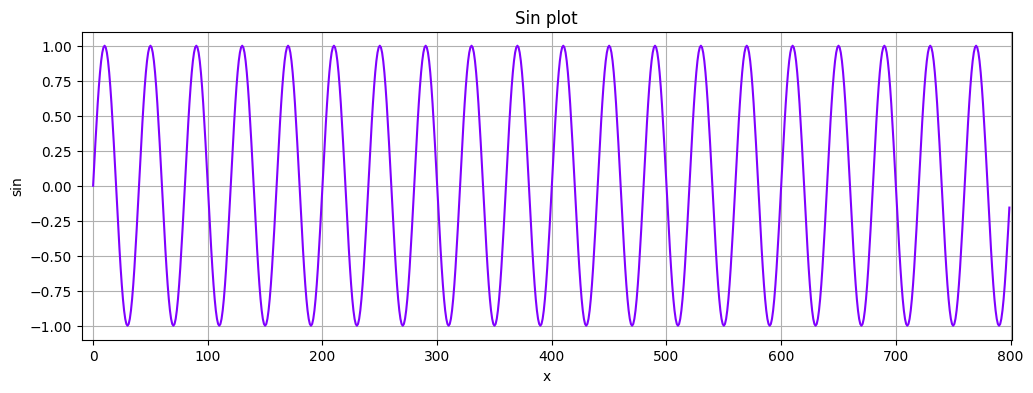

In [5]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(y.numpy(),color='#8000ff')
plt.show()

## 3. Batching the data

3.1 Splitting the data in train/test set

In [ ]:
# y를 전체 시계열 데이터로 사용
# 테스트 데이터 크기 설정 (시계열의 마지막 40개 값을 테스트에 사용)
test_size = 40

# 훈련 데이터셋: 마지막 40개를 제외한 앞부분 (800 - 40 = 760개)
train_set = y[:-test_size]  # shape: (760,)

# 테스트 데이터셋: 시계열 마지막 40개 값
test_set = y[-test_size:]   # shape: (40,)

3.1.1 Plotting the training/test set

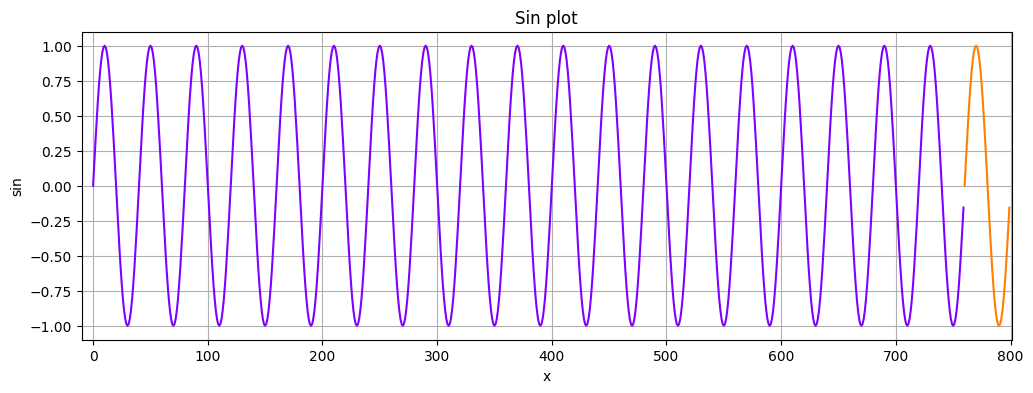

In [7]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(train_set.numpy(),color='#8000ff')
plt.plot(range(760,800),test_set.numpy(),color="#ff8000")
plt.show()

3.2 Creating the batches of data

In [ ]:
# 입력 시퀀스(seq)로부터 (window, label) 쌍을 생성하는 함수
# ws: window_size (몇 개의 연속된 값을 입력으로 사용할 것인가)

def input_data(seq, ws):
    out = []            # 결과를 저장할 리스트
    L = len(seq)        # 전체 시계열 길이

    # 전체 시퀀스를 순회하며 윈도우(window)와 타깃(label) 쌍 생성
    for i in range(L - ws):
        window = seq[i:i+ws]          # 입력: 현재 위치에서 ws개 값
        label = seq[i+ws:i+ws+1]      # 타깃: 그 다음 값 (하나만 예측)
        out.append((window, label))   # 튜플로 저장

    return out  # 최종 리스트 반환 ([(윈도우1, 라벨1), (윈도우2, 라벨2), ...])


3.2.1. Calling the input data function
- The length of x = 800
- The length of train_set = 800 - 40 = 760
- The length of train_data = 760 - 40 - 720

In [9]:
window_size = 40
train_data = input_data(train_set, window_size)
len(train_data)

720

3.2.2 Checking the 1st value from train_data

In [11]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

## 4. Defining the model

4.1 Model Class

In [ ]:
import torch
import torch.nn as nn

# LSTM 기반 시계열 예측 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        # input_size: 입력 피처의 개수
        # hidden size: hidden state의 크기
        # out_size: 출력 피처의 개수 (예측값의 크기)
        super().__init__()  # 부모 클래스 초기화
        self.hidden_size = hidden_size

        # LSTM 레이어: 입력 크기 → hidden state 크기
        self.lstm = nn.LSTM(input_size, hidden_size)

        # 마지막 LSTM 출력 → 예측값으로 변환
        self.linear = nn.Linear(hidden_size, out_size)

        # 초기화 hidden state, cell state (batch=1, layer=1, hidden_size)
        self.hidden = (
            torch.zeros(1, 1, hidden_size),  # h₀
            torch.zeros(1, 1, hidden_size)   # c₀
        )

    def forward(self, seq):
        # 입력 시퀀스 shape: (seq_len, 1, input_size)
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)

        # LSTM 출력 shape: (seq_len, 1, hidden_size)
        # → 선형 변환 후 shape: (seq_len, out_size)
        pred = self.linear(lstm_out.view(len(seq), -1))

        # 마지막 시점의 출력값만 사용
        return pred[-1]


4.2 Model Instantiation

In [ ]:
torch.manual_seed(42) # 시드 고정
model = LSTM() # 모델 생성
criterion = nn.MSELoss() # 손실 함수: 평균 제곱 오차
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # 옵티마이저: Adam(경사하강법 기반의 최적화 알고리즘), 학습률(파라미터가 얼마나 빠르게 바뀔지 조정) 0.01

4.2.1 Printing the model

In [18]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

4.3 Training

Epoch: 0, loss: 0.0019
Performance on test range:0.657501757144928


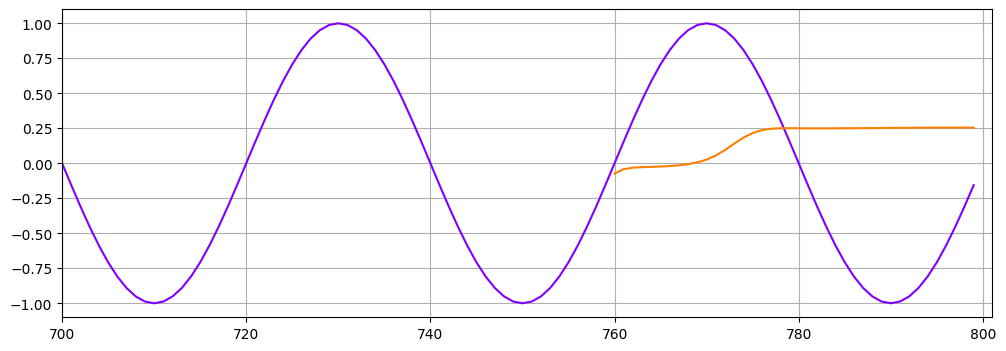

Epoch: 1, loss: 0.0027
Performance on test range:4.3856587409973145


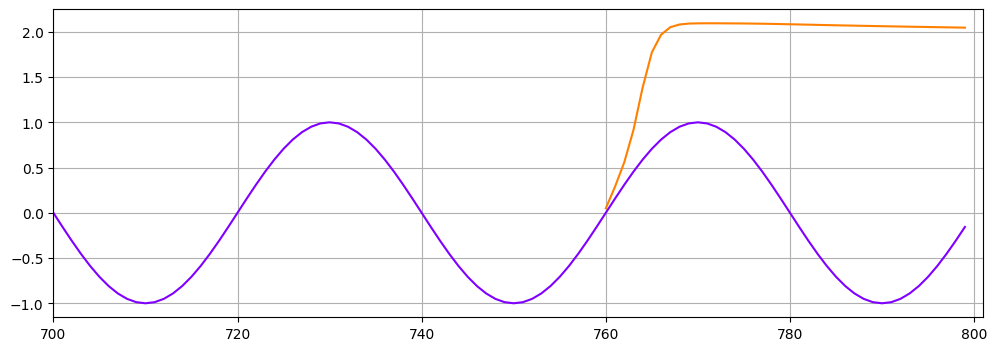

Epoch: 2, loss: 0.0062
Performance on test range:1.8163912296295166


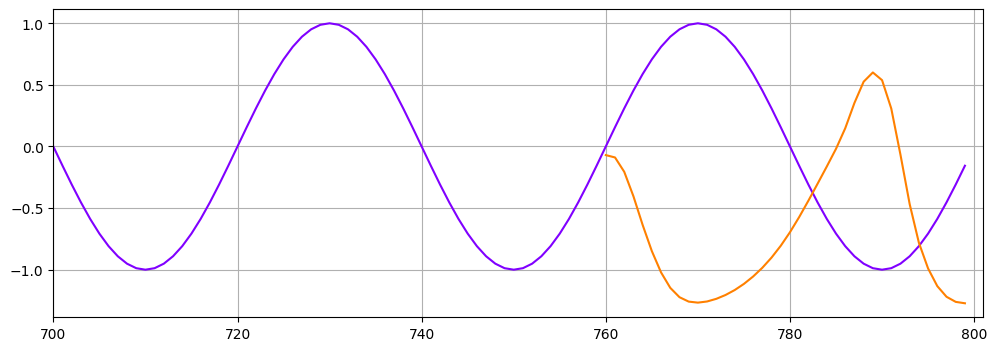

Epoch: 3, loss: 0.0116
Performance on test range:1.7598050832748413


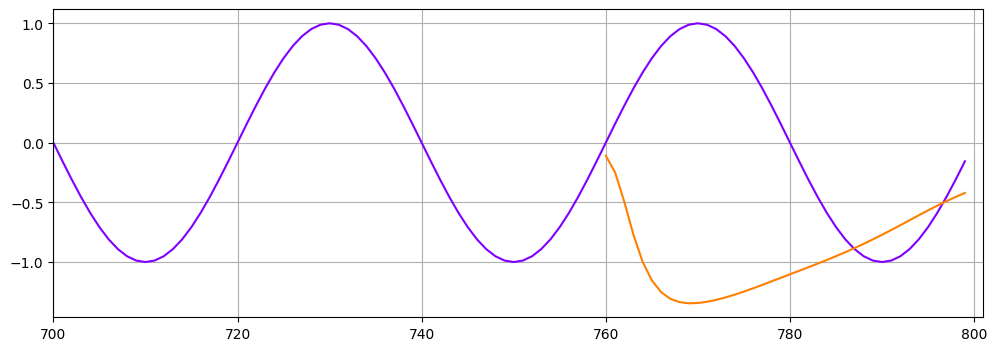

Epoch: 4, loss: 0.0098
Performance on test range:0.8129379153251648


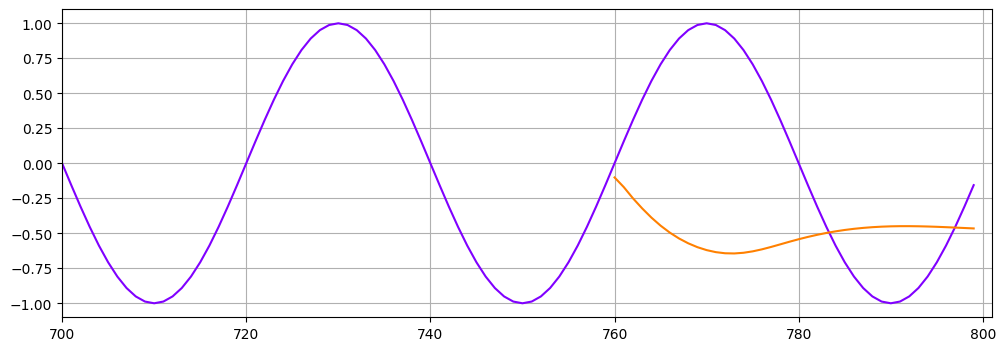

Epoch: 5, loss: 0.0012
Performance on test range:0.5154136419296265


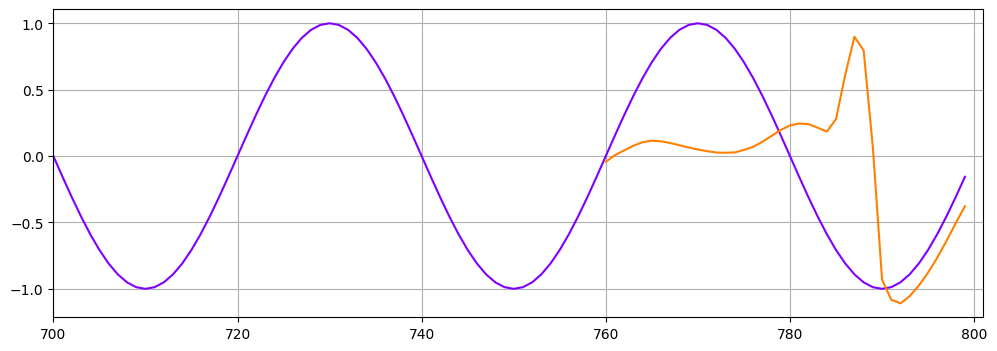

Epoch: 6, loss: 0.0100
Performance on test range:6.690192222595215


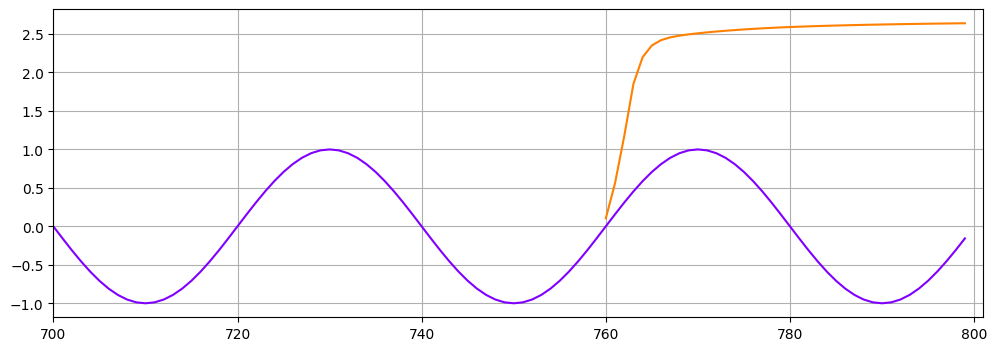

Epoch: 7, loss: 0.0031
Performance on test range:2.8147366046905518


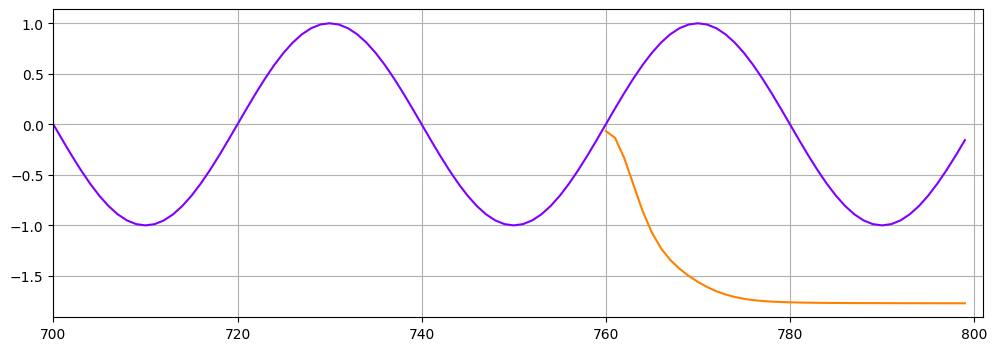

Epoch: 8, loss: 0.0007
Performance on test range:0.7266543507575989


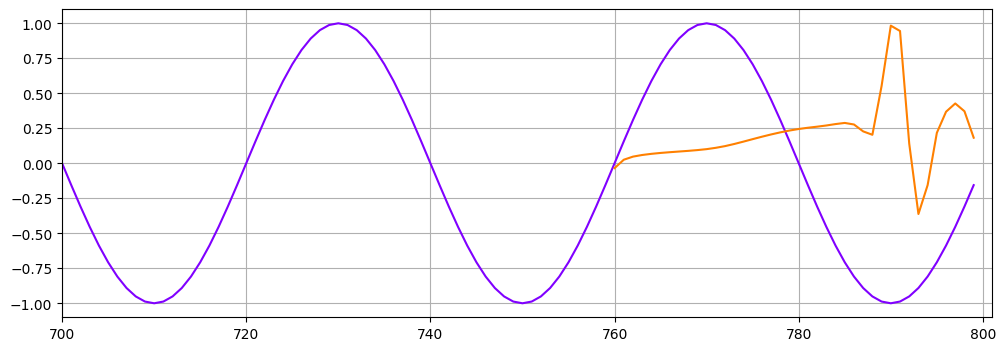

Epoch: 9, loss: 0.0011
Performance on test range:2.298356533050537


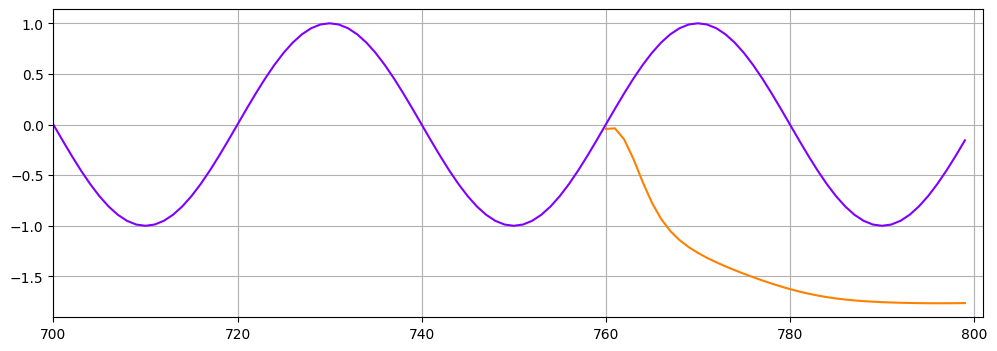

In [ ]:
epochs = 10 # 학습 반복 회수
future = 40 # 미래 예측할 시점 수 (40개 시계열 예측)

for i in range(epochs): # 전체 데이터를 가지고 10번 반복 학습
    for seq, y_train in train_data: # 윈도우 단위, traindata: (윈도우 시퀀스, 정답 값)의 리스트
        optimizer.zero_grad() # 기울기 최소화(매 학습 전에 이전 epoch의 gradient를 초기화, 안 하면 오답 학습 가능성)

        # 매번 hidden state 초기화 (stateless)
        model.hidden = (torch.zeros(1, 1, model.hidden_size), 
                        torch.zeros(1, 1, model.hidden_size))

        # 순전파 (예측)
        # seq: 현재 윈도우 시퀀스 하나 모델에 넣고 다음 값 예측
        y_pred = model(seq)
        loss = criterion(y_pred, y_train) # 손실 계산
        loss.backward() # 역전파 (손실값을 기준으로 gradient 계산)
        optimizer.step() # 최적화 (파라미터 업데이트)

    # 현재 epoch의 마지막 loss 출력
    print("Epoch: %d, loss: %.4f" % (i, loss.item()))

    # 예측 시작: 마지막 train window로 부터 future 예측
    preds = train_set[-window_size:].tolist()

    # 미래 40개 시게열 생성 (Autoregressive 방식)
    # 매번 마지막 window를 모델에 넣어 1 step 예측
    # -> 예측 결과를 다시 다음 window 입력에 포함
    # -> 이 과정을 40번 반복 -> 미래 시계열 완성
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_size), 
                            torch.zeros(1, 1, model.hidden_size))
            preds.append(model(seq).item())

    # 테스트셋 구간과 예측값 비교
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range:{loss}")

    # 시각화 
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(760,800),preds[window_size:],color='#ff8000')
    plt.show()